In [1]:
from keras.models import Sequential
from keras.layers import Conv2D
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Activation
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects

from numpy import asarray
from numpy import save


In [2]:
# Import python library for this notebook
import numpy as np # fundamental package for scientific computing
import matplotlib.pyplot as plt # package for plot function

# show figures inline
%matplotlib inline 

def myimshow(I, **kwargs):
    # utility function to show image
    plt.figure();
    plt.axis('off')
    #plt.imshow(I, cmap=plt.gray(), **kwargs)
    plt.imshow(I,  **kwargs)

(101, 101)

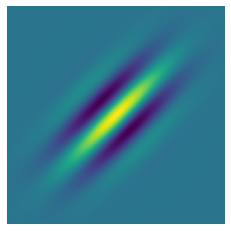

In [3]:
def genGabor(sz, omega, theta, func=np.cos, K=np.pi):
    radius = (int(sz[0]/2.0), int(sz[1]/2.0))
    [x, y] = np.meshgrid(range(-radius[0], radius[0]+1), range(-radius[1], radius[1]+1))

    x1 = x * np.cos(theta) + y * np.sin(theta)
    y1 = -x * np.sin(theta) + y * np.cos(theta)
    
    gauss = omega**2 / (4*np.pi * K**2) * np.exp(- omega**2 / (8*K**2) * ( 4 * x1**2 + y1**2))
#     myimshow(gauss)
    sinusoid = func(omega * x1) * np.exp(K**2 / 2)
#     myimshow(sinusoid)
    gabor = gauss * sinusoid
    return gabor
        
g = genGabor((100,100), 0.3, np.pi/4, func=np.cos) 
# change func to "cos", "sin" can generate sin gabor or cos gabor, here we pass a function name as a parameter
myimshow(g)
np.mean(g)
g.shape

In [4]:
theta = np.arange(0, np.pi, np.pi/8) # range of theta
omega = np.arange(0.1, 0.6, 0.1) # range of omega
print("Theta shape: %i " % theta.shape)
print("Omega shape: %i " % omega.shape)
params = [(t,o) for o in omega for t in theta]
sinFilterBank = []
cosFilterBank = []
gaborParams = []
for (theta, omega) in params:
    gaborParam = {'omega':omega, 'theta':theta, 'sz':(11, 11)}
    sinGabor = genGabor(func=np.sin, **gaborParam)
    cosGabor = genGabor(func=np.cos, **gaborParam)
    sinFilterBank.append(sinGabor)
    cosFilterBank.append(cosGabor)
    gaborParams.append(gaborParam)

Theta shape: 8 
Omega shape: 5 


In [5]:
def custom_activation(x):
    return (K.sigmoid(x) * 5) - 1

In [6]:
get_custom_objects().update({'custom_activation': Activation(custom_activation)})

40


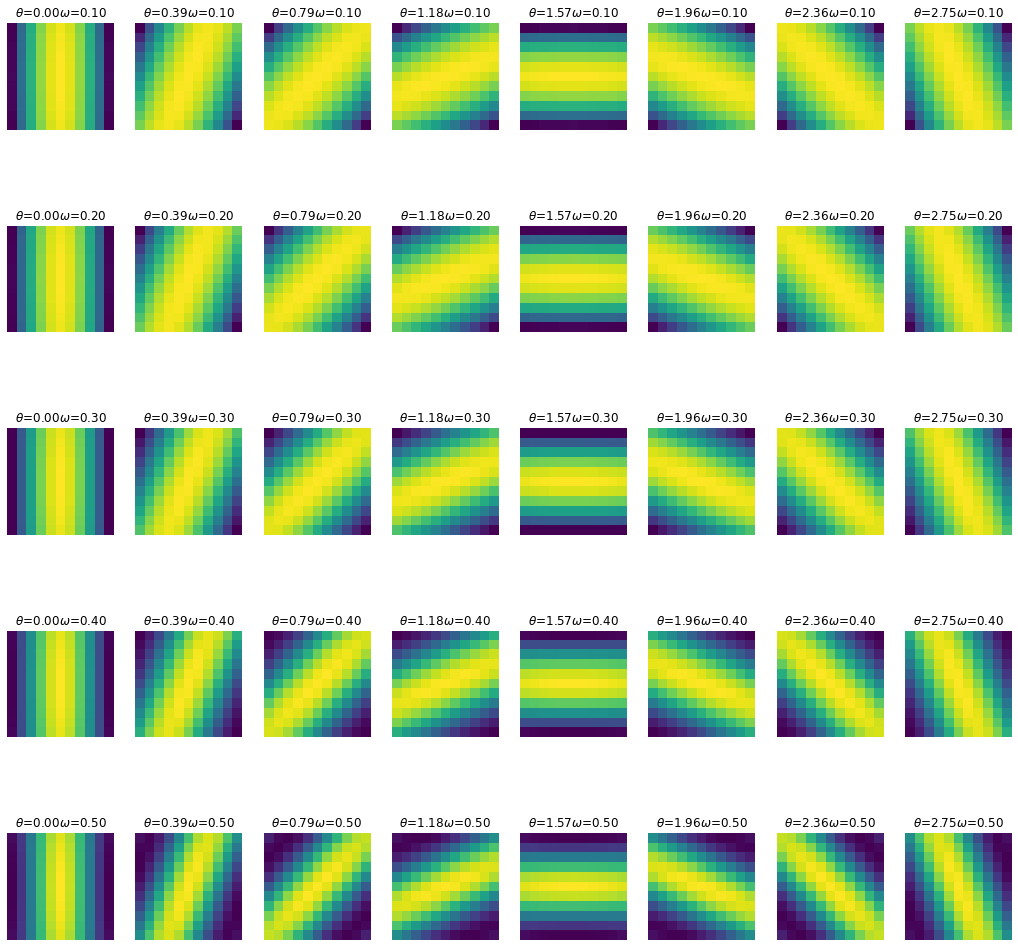

In [7]:
n = len(sinFilterBank)
plt.figure(figsize=(18,18)) #width,length
print(n)
for i in range(n):
    plt.subplot(5,8,i+1)
    plt.title(r'$\theta$={theta:.2f}$\omega$={omega:.2f}'.format(**gaborParams[i]))
    plt.axis('off'); plt.imshow(cosFilterBank[i])
    

(1, 224, 224, 1)

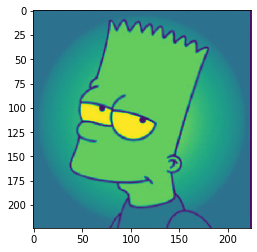

In [8]:
ima = load_img('bart_color.jpeg', target_size=(224, 224),color_mode="grayscale") #VGG user 224 as input
# convert the image to an array
ima = img_to_array(ima)

plt.imshow(ima)
plt.savefig("bart.jpg")

# expand dimensions to match the shape of model input
ima = np.expand_dims(ima, axis=0)
#ima = np.expand_dims(np.expand_dims(np.array(ima),2),0)
ima.shape

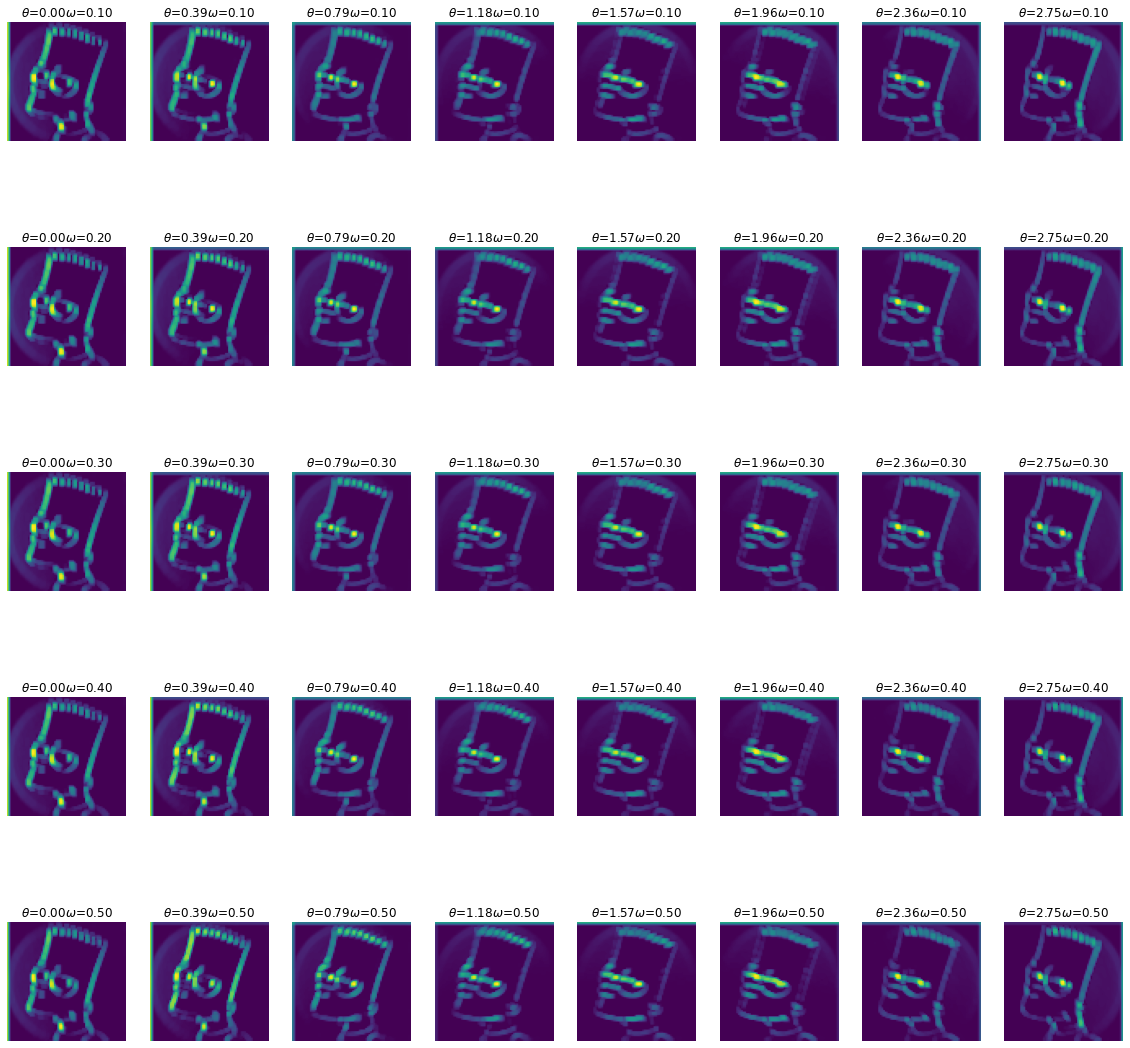

In [33]:
#Initialise to set kernel to required value
Num_kernels= len(sinFilterBank)
def kernel_init(shape,dtype=None):
    kernel = np.zeros(shape)
    #Create the Gabor filters tensor
    for i in range(Num_kernels):
        kernel[:,:,0,i] = np.array(sinFilterBank[i])
    return kernel

#Build Keras model
#Num_kernels
D2=0
model = Sequential()
model.add(Conv2D(Num_kernels, [11,11], kernel_initializer=kernel_init,input_shape=(224,224,1), padding="same",activation='relu'))
model.add(MaxPooling2D((6,6), strides=(3, 3),padding='valid'))
#model.add(Flatten())
#model.add(Dense(4096, activation='relu'))
model.build()


# To apply existing filter, we use predict with no training
out = model.predict(ima)
#rint(out[0,:,:,0])  #if 2D image
#print(out[0,0])  #if 1D image
#rint(out)
#np.savetxt('test.csv',out, delimiter=',')


if(D2==0):
    n = Num_kernels
    plt.figure(figsize=(20,20)) #width,length
    for i in range(n):
        plt.subplot(5,8,i+1)
        plt.title(r'$\theta$={theta:.2f}$\omega$={omega:.2f}'.format(**gaborParams[i]))
        plt.axis('off')
        image2 = np.array(out[0,:,:,i])
        #mage2 = np.array(out[0,i])
        plt.imshow(image2)

In [10]:
# Keras version of this example:
# https://stackoverflow.com/questions/34619177/what-does-tf-nn-conv2d-do-in-tensorflow
# Requires a custom kernel initialise to set to value from example
# kernel = [[1,0,1],[2,1,0],[0,0,1]]
# image = [[4,3,1,0],[2,1,0,1],[1,2,4,1],[3,1,0,2]]
# output = [[14, 6],[6,12]] 

#Set Image

image = [[120,3,1,0,8,5],[2,1,0,1,5,6],[1,2,4,1,6,7],[3,4,0,2,8,6],[1,3,5,6,7,3],[8,6,5,1,1,2]]
image = [[123,3,4,0,0,0],[2,1,9,0,0,0],[1,2,4,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0],[0,0,0,0,0,0]]
image = np.array(image)
img = Image.fromarray(image, 'L')
img.save('my.png')
img.show()

# Pad to "channels_last" format 
# which is [batch, width, height, channels]=[1,4,4,1]
image = np.expand_dims(np.expand_dims(np.array(image),2),0)
image.shape
#(1, 4, 4, 1)

#Initialise to set kernel to required value
def kernel_init(shape,dtype=None):
    kernel = np.zeros(shape)
    kernel[:,:,0,0] = np.array([[0,1,0],[0,1,0],[0,1,0]])
    return kernel

#Build Keras model
model = Sequential()
model.add(Conv2D(1, [3,3], kernel_initializer=kernel_init,input_shape=(4,4,1), padding="same",activation='relu'))
model.add(MaxPooling2D((3,3), strides=(3, 3),padding='same'))
model.add(Flatten())
model.build()


# To apply existing filter, we use predict with no training
out = model.predict(image)
#print(out[0,:,:,0]) #if 2D
print(out[0,0]) #if 2D
print(out[0,1]) #if 2D
print(out[0,2]) #if 2D
print(out[0,3]) #if 2D
print(out)

image = np.array(out[0,:,:,0])
img = Image.fromarray(image, 'L')
img.save('my.png')
img.show()
print(model.summary())

layer = model.layers #Conv layers at 0
filters, biases = model.layers[0].get_weights()
print(layer[0].name, filters.shape)
print(filters)
fig1=plt.figure(figsize=(8, 12))
columns = 3
rows = 3
n_filters = columns * rows
for i in range(1, n_filters +1):
    f = filters[:, :, :, i-1]
    fig1 =plt.subplot(rows, columns, i)
    fig1.set_xticks([])  #Turn off axis
    fig1.set_yticks([])
    plt.imshow(f[:, :, 0], cmap='gray') #Show only the filters from 0th channel (R)
    #ix += 1
plt.show()



126.0
0.0
4.0
0.0
[[126.   0.   4.   0.]]


IndexError: too many indices for array: array is 2-dimensional, but 4 were indexed

In [ ]:
# To apply existing filter, we use predict with no training
out = model.predict(image)
print(out[0,:,:,0])

In [ ]:
w, h = 512, 512
data = np.zeros((h, w, 3), dtype=np.uint8)
data[0:256, 0:256] = [255, 0, 0] # red patch in upper left
img = Image.fromarray(data, 'RGB')
img.save('my.png')
img.show()